In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import combinations, groupby

En este notebook se incluyen los pasos realizados para generar las funciones principales del algoritmo. La referencia principal optimizada es:

- Kochenderfer, M. J., & Wheeler, T. A. (2019). Algorithms for optimization. Mit Press.

En este libro utilizan funciones similares a las utilizadas en este trab

Generando grafos aleatorios

- Nuestros conjuntos de datos implican trabajar con matrices de distancias. Vamos a generar una función que nos permita crear matrices de distancias aleatorias para probar nuestras implementaciones.

In [2]:
def rand_dist_matrix(n_points, graph=True, scale_factor=1, round_factor=4, 
                     seed=1951959, int=False):
    """Crea matriz aleatoria de distancias
    
    Args:
        n_points (int): ńumero de nodos de la matriz de distancias.
        graph (bool): True si se quiere retorna la matriz como un grafo de nwtworkx.
        scale_factor (int): Factor de escala de la matriz.
        round_factor (int): Factor de redondeo de la matriz.
        seed (int): Semilla aleatoria para reproducibilidad de resultados.
        int (bool): True para obtener matriz con distancias de enteros.
    """
    random.seed(seed)
    import scipy.spatial as spatial
    # Basado en https://www.w3resource.com/python-exercises/numpy/python-numpy-random-exercise-12.php
    pts = np.random.random((n_points,2))
    x, y = np.atleast_2d(pts[:,0], pts[:,1])
    # Vector de distancias para cada punto 
    dist_mat = np.sqrt((x - x.T)**2 + (y - y.T)**2)
    if int:
        dist_mat = (dist_mat*scale_factor).round(round_factor)
    # Matriz de distancias
    if graph:
        return nx.from_numpy_matrix(dist_mat) 
    else:
        return dist_mat

- Ejemplo para generar la matriz numérica de distancias 

In [3]:
G_num = rand_dist_matrix(10, graph=False, int=True, scale_factor=100, round_factor=0, seed=1950)
G_num

array([[  0.,  75.,  35.,  83.,  49.,  28.,  75.,  44.,  16.,  32.],
       [ 75.,   0.,  48.,  13.,  32.,  65.,  13.,  50.,  62., 103.],
       [ 35.,  48.,   0.,  52.,  16.,  46.,  44.,  11.,  32.,  57.],
       [ 83.,  13.,  52.,   0.,  36.,  76.,   8.,  52.,  71., 109.],
       [ 49.,  32.,  16.,  36.,   0.,  51.,  27.,  18.,  41.,  73.],
       [ 28.,  65.,  46.,  76.,  51.,   0.,  70.,  56.,  16.,  59.],
       [ 75.,  13.,  44.,   8.,  27.,  70.,   0.,  43.,  64., 101.],
       [ 44.,  50.,  11.,  52.,  18.,  56.,  43.,   0.,  42.,  61.],
       [ 16.,  62.,  32.,  71.,  41.,  16.,  64.,  42.,   0.,  48.],
       [ 32., 103.,  57., 109.,  73.,  59., 101.,  61.,  48.,   0.]])

Necesitaremos crear un diccionario de distancias de los nodos que nos será util para acceder a dicha información más adelante.

In [4]:
def create_dic_dist(dist):
    """Descripcion
    
    Args:
    
    Returns:
    
    Example:
    """
    lenghts = {}
    for node, z in enumerate(dist):
        lenghts[node] = {}
        for neighbor, y in enumerate(z):
            lenghts[node][neighbor] = y
    return lenghts    

- Ejemplo de diccionario de distancias para 10 nodos:

In [5]:
lenghts = create_dic_dist(G_num)
lenghts[0]

{0: 0.0,
 1: 75.0,
 2: 35.0,
 3: 83.0,
 4: 49.0,
 5: 28.0,
 6: 75.0,
 7: 44.0,
 8: 16.0,
 9: 32.0}

Nuestra funcíon tambíen puede generar el grafo asociado a la matriz de distancias para visualizaciones útiles, de la siguiente manera:

In [6]:
G = rand_dist_matrix(10, int=True, scale_factor=10, round_factor=4, seed=1950)

Visualizar los nodos y sus costos asociados es muy útil en este tipo de problemas. A continuación generamos una función que nos permite realizar dicha tarea de dos formas: 1. Como grafo, 2. En un plano de coordenadas. 

**Pendiente:** Incluir costos en los arcos del grafo. 

In [7]:
def plot_graph(G, m_plot, seed=19511959):
    pos = nx.fruchterman_reingold_layout(G, center=(0,0), seed=seed) 
    colors = range(20)
    if m_plot=='coordinate':
        plt.figure(figsize=(7, 7))
        for k, p in pos.items():
            plt.scatter(p[0], p[1], marker='o', s=50, edgecolor='None')
        plt.tight_layout()
        plt.axis('equal')
        plt.show()
    elif m_plot=='graph': 
        edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
        
        nx.draw(G, 
                node_color='lightblue', 
                with_labels=True,
                edge_color = [i[2]['weight'] for i in G.edges(data=True)], 
                edge_cmap=plt.cm.Blues, 
                pos=pos)

- Ejemplo de visualización de grafo:

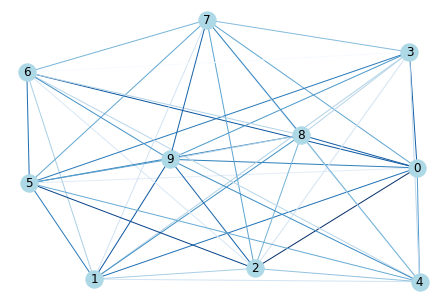

In [8]:
plot_graph(G, m_plot='graph')

- Ejemplo de visualización de coordenadas:

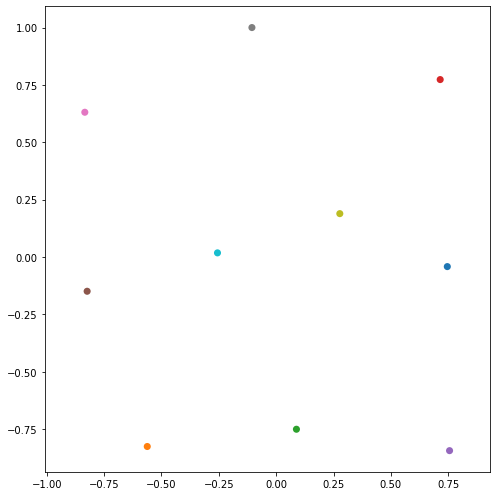

In [9]:
plot_graph(G, m_plot='coordinate')

**Exploración de elemenots útiles del grafo para la generación del algorimo**

- Listar nodos:

In [10]:
nodos = list(G.nodes)
nodos

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

- Encontrar vecinos de un nodo:

In [11]:
neighbors = list(G.neighbors(2))
neighbors

[0, 1, 3, 4, 5, 6, 7, 8, 9]

- Para la generación de nuestro algoritmo es necesario crear el grado de atracción de cada nodo, $v$:
$$
v = \tau_{i,j}^{\alpha} \eta_{i,j}^{\beta}
$$

Como se puede observar, es necesario computar el nivel de atracción $\eta$ de cada nodo y el nivel de feromonas de cada nodo $\tau$.

In [12]:
# inicializar diccionario de niveles de feromonas de los nodos
def init_ferom(G, init_lev=1):
    """Descripción
    
        Args:
        Returns:
        * Ejemplo:
    """
    nodos = list(G.nodes)
    tau = {}

    for nodo in nodos:
        tau[nodo] = {}
        neighbors = list(G.neighbors(nodo))
        for neighbor in neighbors:
            tau[nodo][neighbor] = init_lev
    return tau

# inicializar niveles de atracción de cada nodo
def init_atrac(G, lenghts):
    """Descripción
    
        Args:
        Returns:
        * Ejemplo:
    """
    nodos = list(G.nodes)
    eta = {}
    
    for nodo in nodos:
        eta[nodo] = {}
        neighbors = list(G.neighbors(nodo))
        for neighbor in neighbors:
            eta[nodo][neighbor] = 1/lenghts[nodo][neighbor]
    return eta

# atracción de cada nodo
def atraccion_nodos(G, tau, eta, alpha=1, beta=5):    
    """Calcula el grado de atracción de un nodo n perteneciente al grafo G.

    Args:
        G (networkx graph): Grafo de networkx.
        tau (dic): Diccionario con niveles de feromonas de los vecinos de cada nodo.
        eta (dic): Diccionario con nive de atracción de los vecinos de cada nodo.
        alpha (float): Factor de influencia (exponente del nivel de feronomas).
        beta (int): exponente anterior.

    Returns:
        atrac: Diccionario con los valores de atracción de los vecinos del nodo j.
    """
    dic_attr = {}
    # componentes del grafo
    nodos = list(G.nodes)
    
    
    for nodo in nodos:
        dic_attr[nodo] = {}
        neighbors = list(G.neighbors(nodo))
        for neighbor in neighbors:
            attr = tau[nodo][neighbor]**alpha + eta[nodo][neighbor]**beta
            dic_attr[nodo][neighbor] = attr
        
    return dic_attr

- Ejemplo de diccionario de nivel de atracción de cada nodo:

In [13]:
tau = init_ferom(G)
eta = init_atrac(G, lenghts)

A = atraccion_nodos(G, tau, eta, alpha=1, beta=5)
A[0]

{1: 1.0000000004213991,
 2: 1.0000000190396858,
 3: 1.000000000253869,
 4: 1.000000003540133,
 5: 1.00000005810451,
 6: 1.0000000004213991,
 7: 1.0000000060636849,
 8: 1.0000009536743164,
 9: 1.0000000298023224}

- Recorrido de los nodos por una hormiga

In [14]:
def hormiga_recorre(G, lenghts, dic_attr, tau, init_point, x_best, y_best):
    """Calcula el grado de atracción de un nodo n perteneciente al grafo G.

    Args:
        G (networkx graph): Grafo de networkx.
        dic_attr (): 
        eta:
        alpha (float): Factor de influencia (exponente del nivel de feronomas)
        beta: exponente anterior

    Returns:
    eta = init_atrac()rns:
        atrac: Lista con los valores de atracción de los vecinos del nodo j.
    """

    A = dic_attr
    x = [init_point]
    nodos = list(G.nodes) 
    while len(x) < len(nodos):
        i = x[-1]
        neighbors = set(list(G.neighbors(i))) - set(x)
        if len(neighbors) == 0:
            return(x_best, y_best)
        
        a_s = [A[i][j] for j in neighbors]
        next_ = random.choices(list(neighbors), weights= a_s)
        x = x + next_
    # distancia total del recorrido (se adiciona retorno al origen)
    l = sum([lenghts[i-1][i] for i in range(1, len(x))]) + lenghts[x[-1]][init_point] 
    # aportación a los niveles de feromonas
    for i in range(1, len(x)):
        tau[i-1][i] += 1/l  
        
    tau[x[-1]][init_point] += 1/l
    # aportación a los niveles de feromonas
    # sumar regreso al origen
    x = x + [init_point]
    
    if l < y_best:
        return (x, l)
    else:
        return x_best, y_best, A
    

- Ejemplo de recorrido de una hormiga:

In [15]:
route, dist = hormiga_recorre(G,lenghts, A, tau, 1, x_best=[], y_best= float('inf'))

print(f'Ruta: {route}')
print(f'Distance: {dist}')

Ruta: [1, 3, 8, 0, 7, 5, 4, 9, 2, 6, 1]
Distance: 478.0


Como ya hemos mencionado, visualizar nos podría ayudar a entender mejor que está haciendo nuesro algoritmo.
A continuación generamos una gráfica.

In [16]:
def graph_optim_path(G, best_route, best_dist):
    seed=19511959
    pos = nx.fruchterman_reingold_layout(G, center=(0,0), seed=seed) 
    
    edges = []
    route_edges = [(best_route[n],best_route[n+1]) for n in range(len(best_route)-1)]
    G.add_nodes_from(best_route)
    G.add_edges_from(route_edges)
    edges.append(route_edges)
    
    # graph info
    textstr = '\n'.join((
    f'Distancia: {round(best_dist, 2)}',
    f'Ruta: {best_route}',
    ))
    
    fig, ax = plt.subplots()
    
    g = nx.DiGraph()
    g.add_nodes_from(best_route)
    nx.draw_networkx_nodes(g, ax=ax, pos=pos)
    nx.draw_networkx_labels(g, ax=ax, pos=pos)
    colors = ['b']
    linewidths = [5]
    
    
    
    for ctr, edgelist in enumerate(edges):
                           nx.draw(g,
                           node_color='lightblue', 
                           arrows=True, 
                           pos=pos,
                           edgelist=edgelist,
                           edge_color = colors[ctr], 
                           width=linewidths[ctr])
    # textbox
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.001, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    

- Ejemplo de visualización para el recorrido de una sola hormiga.

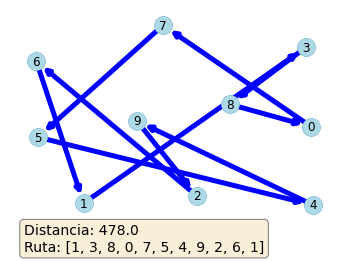

In [17]:
graph_optim_path(G, route, dist)

# Algoritmo principal de Ant Colony

A continuación implementamos el algoritmo _Ant Colony_ con un criterio de parada, **número máximo de iteraciones**.

In [18]:
def ant_colony(G, lenghts, init=0, graph=True, ants=200, max_iter=100, 
               alpha=1, beta=5, rho=.5, verbose=True):
    """ Descripción
    
    Args:
        ants (int): Número de hormigas por iteracion.
        max_iter (int): Número máximo de iteraciones.
        alpha (float): exponente de feromonas.
        beta (float): exponente prior.
        rho (float): tasa de evaporación.
        
    Returns:
    
    Example:
        
    """
    # iniciales
    x_best=[]
    y_best= float('inf')
    
    tau = init_ferom(G)
    eta = init_atrac(G,lenghts)
    #G_num = rand_dist_matrix(n_nodos, int=True, scale_factor=10, round_factor=4, seed=1950)

    for k in range(1, max_iter + 1):
        
        A = atraccion_nodos(G, tau, eta, alpha=1, beta=5)
        for e in tau:
            for v in tau:
                tau[e][v] = (1-rho)*v
                
        for ant in range(1, ants + 1):
            x_best, y_best = hormiga_recorre(G,lenghts,  A, tau, init, x_best, y_best)
            
        if verbose:
            if k%10 == 0:
                print(f'{k} / {max_iter} iteraciones - Distancia: {round(y_best, 2)}')
        
        
    if graph:
        graph_optim_path(G, x_best, y_best)

    return x_best,y_best

## Ejemplo completo para un grafo aleatorio de 20 nodos

> **Reiniciar _kernel_ y correr desde el _chunk_ de abajo.**

In [1]:
%%writefile aco_algo.py

import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import combinations, groupby

def rand_dist_matrix(n_points, graph=True, scale_factor=1, round_factor=4, 
                     seed=1951959, int=False):
    """Crea matriz aleatoria de distancias
    
    Args:
        n_points (int): ńumero de nodos de la matriz de distancias.
        graph (bool): True si se quiere retorna la matriz como un grafo de nwtworkx.
        scale_factor (int): Factor de escala de la matriz.
        round_factor (int): Factor de redondeo de la matriz.
        seed (int): Semilla aleatoria para reproducibilidad de resultados.
        int (bool): True para obtener matriz con distancias de enteros.
    """
    random.seed(seed)
    import scipy.spatial as spatial
    # Basado en https://www.w3resource.com/python-exercises/numpy/python-numpy-random-exercise-12.php
    pts = np.random.random((n_points,2))
    x, y = np.atleast_2d(pts[:,0], pts[:,1])
    # Vector de distancias para cada punto 
    dist_mat = np.sqrt((x - x.T)**2 + (y - y.T)**2)
    if int:
        dist_mat = (dist_mat*scale_factor).round(round_factor)
    # Matriz de distancias
    if graph:
        return nx.from_numpy_matrix(dist_mat) 
    else:
        return dist_mat
    
def create_dic_dist(dist):
    """Descripcion
    
    Args:
    
    Returns:
    
    Example:
    """
    lenghts = {}
    for node, z in enumerate(dist):
        lenghts[node] = {}
        for neighbor, y in enumerate(z):
            lenghts[node][neighbor] = y
    return lenghts 

def create_dic_dist_from_graph(G):
    """Descripcion
    
    Args:
    
    Returns:
    
    Example:
    """
    nodos = list(G.nodes)
    G_num = nx.to_numpy_matrix(G)
    lenghts = {}
    for node, z in enumerate(G_num):
        lenghts[node] = {}
        for neighbor in nodos:
            lenghts[node][neighbor] = z[0, neighbor]

    return lenghts  

def plot_graph(G, m_plot, seed=19511959):
    """Descripcion
    
    Args:
    
    Returns:
    
    Example:
    """
    pos = nx.fruchterman_reingold_layout(G, center=(0,0), seed=seed) 
    colors = range(20)
    if m_plot=='coordinate':
        plt.figure(figsize=(7, 7))
        for k, p in pos.items():
            plt.scatter(p[0], p[1], marker='o', s=50, edgecolor='None')
        plt.tight_layout()
        plt.axis('equal')
        plt.show()
    elif m_plot=='graph': 
        edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
        
        nx.draw(G, 
                node_color='lightblue', 
                with_labels=True,
                edge_color = [i[2]['weight'] for i in G.edges(data=True)], 
                edge_cmap=plt.cm.Blues, 
                pos=pos)
        
# inicializar diccionario de niveles de feromonas de los nodos
def init_ferom(G, init_lev=1):
    """Descripción
    
        Args:
        Returns:
        * Ejemplo:
    """
    nodos = list(G.nodes)
    tau = {}

    for nodo in nodos:
        tau[nodo] = {}
        neighbors = list(G.neighbors(nodo))
        for neighbor in neighbors:
            tau[nodo][neighbor] = init_lev
    return tau

# inicializar niveles de atracción de cada nodo
def init_atrac(G, lenghts):
    """Descripción
    
        Args:
        Returns:
        * Ejemplo:
    """
    nodos = list(G.nodes)
    eta = {}
    
    for nodo in nodos:
        eta[nodo] = {}
        neighbors = list(G.neighbors(nodo))
        for neighbor in neighbors:
            #eta[nodo][neighbor] = 1/lenghts[nodo][neighbor]
            eta[nodo][neighbor] = 1
    return eta

# atracción de cada nodo
def atraccion_nodos(G, tau, eta, alpha=1, beta=5):    
    """Calcula el grado de atracción de un nodo n perteneciente al grafo G.

    Args:
        G (networkx graph): Grafo de networkx.
        tau (dic): Diccionario con niveles de feromonas de los vecinos de cada nodo.
        eta (dic): Diccionario con nive de atracción de los vecinos de cada nodo.
        alpha (float): Factor de influencia (exponente del nivel de feronomas).
        beta (int): exponente anterior.

    Returns:
        atrac: Diccionario con los valores de atracción de los vecinos del nodo j.
    """
    dic_attr = {}
    # componentes del grafo
    nodos = list(G.nodes)
    
    
    for nodo in nodos:
        dic_attr[nodo] = {}
        neighbors = list(G.neighbors(nodo))
        for neighbor in neighbors:
            attr = tau[nodo][neighbor]**alpha + eta[nodo][neighbor]**beta
            dic_attr[nodo][neighbor] = attr
        
    return dic_attr

def hormiga_recorre(G, lenghts, dic_attr, tau, init_point, x_best, y_best):
    """Calcula el grado de atracción de un nodo n perteneciente al grafo G.

    Args:
        G (networkx graph): Grafo de networkx.
        dic_attr (): 
        eta:
        alpha (float): Factor de influencia (exponente del nivel de feronomas)
        beta: exponente anterior

    Returns:
    eta = init_atrac()rns:
        atrac: Lista con los valores de atracción de los vecinos del nodo j.
    """
    random.seed(random.randint(0, 1000))
    A = dic_attr
    x = [init_point]
    nodos = list(G.nodes) 
    while len(x) < len(nodos):
        i = x[-1]
        neighbors = set(list(G.neighbors(i))) - set(x)
        if len(neighbors) == 0:
            return(x_best, y_best)
        
        a_s = [A[i][j] for j in neighbors]
        next_ = random.choices(list(neighbors), weights= a_s)
        x = x + next_
    # distancia total del recorrido (se adiciona retorno al origen)
    l = sum([lenghts[i-1][i] for i in range(1, len(x))]) + lenghts[x[-1]][init_point] 
    # aportación a los niveles de feromonas
    for i in range(1, len(x)):
        tau[i-1][i] += 1/l  
        
    tau[x[-1]][init_point] += 1/l
    # aportación a los niveles de feromonas
    # sumar regreso al origen
    x = x + [init_point]
    
    if l < y_best:
        return x, l
    else:
        return x_best, y_best
    

def graph_optim_path(G, best_route, best_dist):
    """ Descripción
    
    Args:
        ants (int): Número de hormigas por iteracion.
        max_iter (int): Número máximo de iteraciones.
        alpha (float): exponente de feromonas.
        beta (float): exponente prior.
        rho (float): tasa de evaporación.
        
    Returns:
    
    Example:
        
    """
    seed=19511959
    pos = nx.fruchterman_reingold_layout(G, center=(0,0), seed=seed) 
    
    edges = []
    route_edges = [(best_route[n],best_route[n+1]) for n in range(len(best_route)-1)]
    G.add_nodes_from(best_route)
    G.add_edges_from(route_edges)
    edges.append(route_edges)
    
    # graph info
    textstr = '\n'.join((
    f'Distancia: {round(best_dist, 2)}',
    f'Ruta: {best_route}',
    ))
    
    fig, ax = plt.subplots()
    
    g = nx.DiGraph()
    g.add_nodes_from(best_route)
    nx.draw_networkx_nodes(g, ax=ax, pos=pos)
    nx.draw_networkx_labels(g, ax=ax, pos=pos)
    colors = ['b']
    linewidths = [5]
    
    
    
    for ctr, edgelist in enumerate(edges):
                           nx.draw(g,
                           node_color='lightblue', 
                           arrows=True, 
                           pos=pos,
                           edgelist=edgelist,
                           edge_color = colors[ctr], 
                           width=linewidths[ctr])
    # textbox
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.001, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

def ant_colony(G, lenghts, init=0, graph=True, ants=200, max_iter=100, 
               alpha=1, beta=5, rho=.5, verbose=True):
    """ Descripción
    
    Args:
        ants (int): Número de hormigas por iteracion.
        max_iter (int): Número máximo de iteraciones.
        alpha (float): exponente de feromonas.
        beta (float): exponente prior.
        rho (float): tasa de evaporación.
        
    Returns:
    
    Example:
        
    """
    # iniciales
    x_best=[]
    y_best= float('inf')
    
    tau = init_ferom(G)
    eta = init_atrac(G,lenghts)
    for k in range(1, max_iter + 1):
        A = atraccion_nodos(G, tau, eta, alpha=1, beta=5)
        for e in tau:
            for v in tau:
                tau[e][v] = (1-rho)*v
                
        for ant in range(1, ants + 1):
            x_best, y_best = hormiga_recorre(G,lenghts,  A, tau, init, x_best, y_best)
            
        if k%verbose == 0 or k==1:
            print(f'{k} / {max_iter} iteraciones - distancia: {round(y_best, 2)}')
        
        
    if graph:
        graph_optim_path(G, x_best, y_best)

    return x_best,y_best

Overwriting aco_algo.py


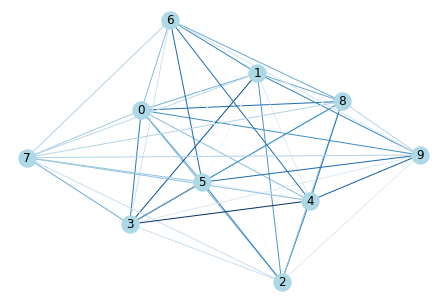

In [2]:
# crear grafo
from aco_algo import *
seed = 101934
n_nodos = 10
X = rand_dist_matrix(n_nodos, int=True, scale_factor=100, round_factor=4, seed=seed)
X_num = rand_dist_matrix(n_nodos, graph=False, int=True, scale_factor=10, round_factor=4, seed=seed)
# diccionario de distancias
dic_dists = create_dic_dist(X_num)

plot_graph(X, m_plot='graph')

1 / 500 iteraciones - distancia: 39.11
20 / 500 iteraciones - distancia: 36.02
40 / 500 iteraciones - distancia: 36.02
60 / 500 iteraciones - distancia: 36.02
80 / 500 iteraciones - distancia: 36.02
100 / 500 iteraciones - distancia: 36.02
120 / 500 iteraciones - distancia: 36.02
140 / 500 iteraciones - distancia: 36.02
160 / 500 iteraciones - distancia: 36.02
180 / 500 iteraciones - distancia: 36.02
200 / 500 iteraciones - distancia: 36.02
220 / 500 iteraciones - distancia: 36.02
240 / 500 iteraciones - distancia: 36.02
260 / 500 iteraciones - distancia: 36.02
280 / 500 iteraciones - distancia: 36.02
300 / 500 iteraciones - distancia: 36.02
320 / 500 iteraciones - distancia: 36.02
340 / 500 iteraciones - distancia: 36.02
360 / 500 iteraciones - distancia: 36.02
380 / 500 iteraciones - distancia: 36.02
400 / 500 iteraciones - distancia: 36.02
420 / 500 iteraciones - distancia: 36.02
440 / 500 iteraciones - distancia: 36.02
460 / 500 iteraciones - distancia: 36.02
480 / 500 iteraciones 

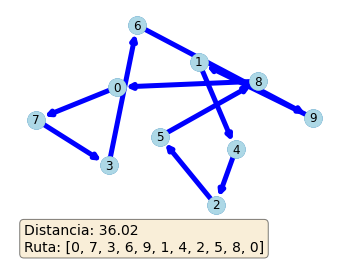

In [3]:
# antcolony
ruta, dist = ant_colony(X, dic_dists, ants=3, max_iter=500, verbose=20)

## Aplicación con dataset


> Reiniciar _kernel_ y correr desde el _chunk_ de abajo.

In [1]:
# usando el modulo del repo
import sys
sys.path.append('..')

In [2]:
from src.ant_colony.aco_tsp import *

In [5]:
import tsplib95
data_path2 = '../datasets/gr17.tsp'

In [6]:
problem = tsplib95.load(data_path2)
G = problem.get_graph()
G_num = nx.to_numpy_matrix(G)
# diccionario de distancias
dic_dists = create_dic_dist_from_graph(G)
tau = init_ferom(G)
eta = init_atrac(G,dic_dists)
A = atraccion_nodos(G, tau, eta, alpha=1, beta=5)
route, dist = hormiga_recorre(G,dic_dists, A, tau, 1, x_best=[], y_best= float('inf'))

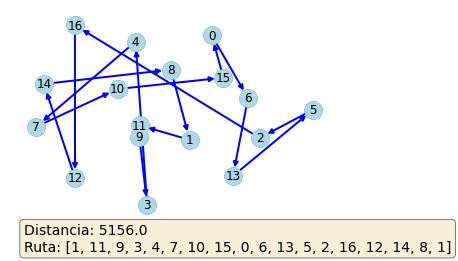

In [7]:
graph_optim_path(G, route, dist)

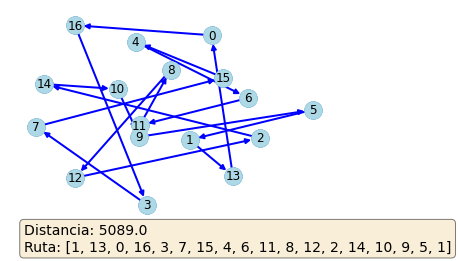

In [8]:
route, dist = hormiga_recorre(G,dic_dists, A, tau, 1, x_best=[], y_best= float('inf'))
graph_optim_path(G, route, dist)

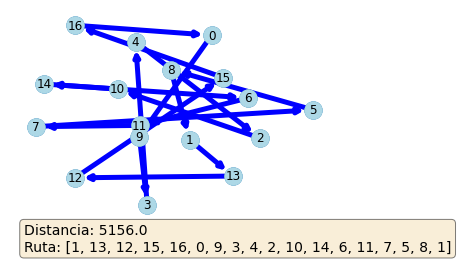

In [7]:
route, dist = hormiga_recorre(G,dic_dists, A, tau, 1, x_best=[], y_best= float('inf'))
graph_optim_path(G, route, dist)

In [8]:
problem = tsplib95.load(data_path2)
G = problem.get_graph()
G_num = nx.to_numpy_matrix(G)
# diccionario de distancias
#dic_dists = create_dic_dist(G_num)
dic_dists = create_dic_dist_from_graph(G)

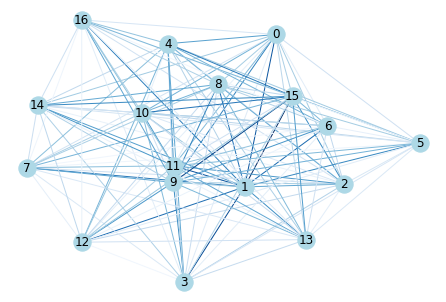

In [9]:
plot_graph(G, m_plot='graph')

1 / 500 iteraciones - distancia: 5089.0
100 / 500 iteraciones - distancia: 4828.0
200 / 500 iteraciones - distancia: 4828.0
300 / 500 iteraciones - distancia: 4828.0
400 / 500 iteraciones - distancia: 4828.0
500 / 500 iteraciones - distancia: 4828.0


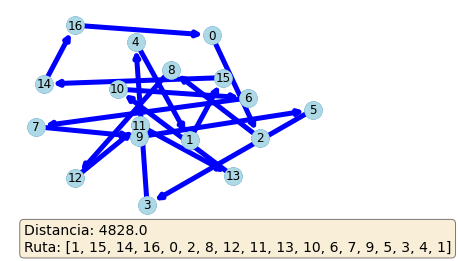

In [13]:
# antcolony
ruta, dist = ant_colony(G, dic_dists, init=1,ants=3, max_iter=500, verbose=100)